# Leverage & Margin Trading

## Getting started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [2]:
# Version 5.1 (Stop Loss & Take Profit)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True):
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [3]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [4]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [5]:
tester.test_strategy(201, 101)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126


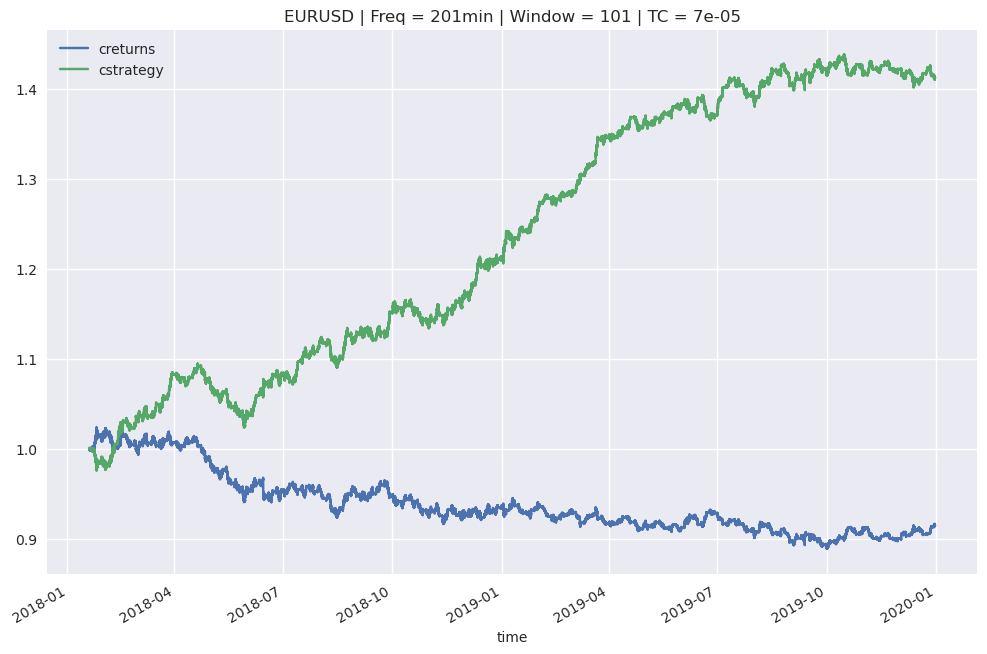

In [6]:
tester.plot_results()

In [7]:
data = tester.results.copy()
data

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820
...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200


In [8]:
data["simple_ret"] = np.exp(data.strategy) - 1

In [9]:
data

,price,returns,position,strategy,trades,creturns,cstrategy,simple_ret
time,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,-0.000049
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.000016
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,-0.000098
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,-0.000049
...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000


In [10]:
data.simple_ret.add(1).prod() # sanity check

1.4122249641297289

## The optimal degree of leverage and the Kelly Criterion

In [11]:
data

,price,returns,position,strategy,trades,creturns,cstrategy,simple_ret
time,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,-0.000049
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.000016
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,-0.000098
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,-0.000049
...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,0.000000


In [12]:
leverage = np.arange(1, 50, 0.1)
leverage

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [13]:
multiple = []
for lever in leverage:
    levered_returns = data.simple_ret.mul(lever)
    levered_returns = pd.Series(np.where(levered_returns < -1, -1, levered_returns))
    multiple.append(levered_returns.add(1).prod())
results = pd.DataFrame(data = {"Leverage":list(leverage), "Multiple":multiple})

In [14]:
results.set_index("Leverage", inplace = True)

In [15]:
results

,Multiple
Leverage,
1.0,1.412225
1.1,1.461107
1.2,1.511547
1.3,1.563590
1.4,1.617281
...,...
49.5,613.980599
49.6,608.426033
49.7,602.868004


In [16]:
results.min()

Multiple    1.412225
dtype: float64

In [17]:
results.max()

Multiple    971.808911
dtype: float64

In [18]:
results.idxmax()

Multiple    39.3
dtype: float64

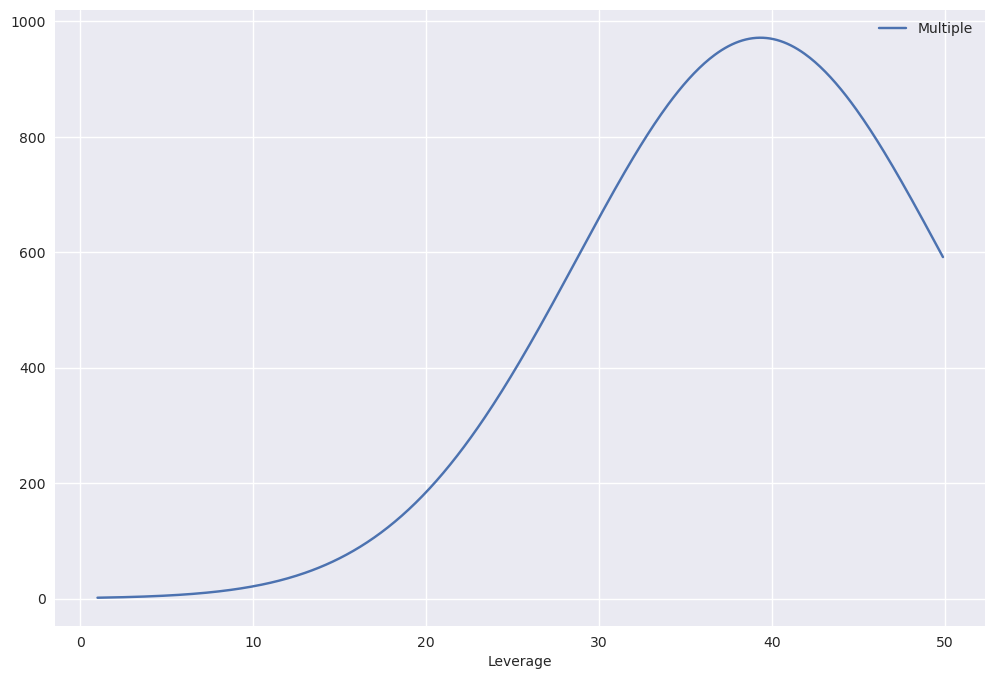

In [19]:
results.plot(figsize = (12, 8));
plt.show()

In [20]:
kelly = data.simple_ret.mean() /  data.simple_ret.var()
kelly

39.361260044516804

__-> Kelly Criterion (almost) perfectly approximates the true/correct optimal degree of Leverage (very large dataset)__

A Multiple of ~ 1000 seems to be too godd to be true!?

__Yes, underlying assumption__: We __keep the leverage constant__ and restore every minute -> __Excessive Trading__

## A more realistic Approach (non-constant Leverage) (Part 1)

In [21]:
import pandas as pd
import numpy as np

__Initial Assumption (no leverage): We buy (long) 100 units of an Instrument @ initial price of 1 -> Initial Trade Value: 100__. <br>
__We keep the long position until the end of day 3 (without further trades)__.

In [22]:
df = pd.DataFrame(data = {"Price": [1, 1.1, 1.25, 1.3], "Units": [100, 100, 100, 100]}, index = [0, 1, 2, 3])
df

,Price,Units
0,1.00,100
1,1.10,100
2,1.25,100
3,1.30,100


In [23]:
df["Trade_Value"] = df.Price * df.Units # Trade Value over time
df

,Price,Units,Trade_Value
0,1.00,100,100.0
1,1.10,100,110.0
2,1.25,100,125.0
3,1.30,100,130.0


In [24]:
df["Returns"] = df.Trade_Value.pct_change() # simple Returns
df

,Price,Units,Trade_Value,Returns
0,1.00,100,100.0,NaN
1,1.10,100,110.0,0.100000
2,1.25,100,125.0,0.136364
3,1.30,100,130.0,0.040000


In [25]:
df["Compound"] = df.Returns.add(1).cumprod() - 1 # compound simple Returns
df

,Price,Units,Trade_Value,Returns,Compound
0,1.00,100,100.0,NaN,NaN
1,1.10,100,110.0,0.100000,0.10
2,1.25,100,125.0,0.136364,0.25
3,1.30,100,130.0,0.040000,0.30


__New Assumption: Same as before but now we trade with leverage of 2 -> We post a Margin of 50 (50% of initial Trade Value)__.

In [26]:
leverage = 2
leverage

2

In [27]:
df["Margin"] = df.Trade_Value[0] / leverage # Margin Account with 50
df

,Price,Units,Trade_Value,Returns,Compound,Margin
0,1.00,100,100.0,NaN,NaN,50.0
1,1.10,100,110.0,0.100000,0.10,50.0
2,1.25,100,125.0,0.136364,0.25,50.0
3,1.30,100,130.0,0.040000,0.30,50.0


In [28]:
df["PL_unreal"] = df.Trade_Value - df.Trade_Value[0] # unrealized Profit / Loss of our long position over time
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal
0,1.00,100,100.0,NaN,NaN,50.0,0.0
1,1.10,100,110.0,0.100000,0.10,50.0,10.0
2,1.25,100,125.0,0.136364,0.25,50.0,25.0
3,1.30,100,130.0,0.040000,0.30,50.0,30.0


In [29]:
df["Equity"] = df.Margin + df.PL_unreal # our net wealth (Equity) over time == Margin + unreal P&L
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0


In [30]:
df["Equity_Returns"] = df.Equity.pct_change() # simple returns of our Equity position
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667


Problem: Typically, we don´t have Margin, PL_unreal & Equity in our DataFrame. -> __Calculate Equity (levered) return with leverage__.

In [31]:
df.Returns * leverage # try to calculate equity returns with constant leverage -> incorrect as this assumes constant leverage of 2 

0         NaN
1    0.200000
2    0.272727
3    0.080000
Name: Returns, dtype: float64

In [32]:
df["EL"] = df.Trade_Value / df.Equity # calculate the effective leverage
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns,EL
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN,2.000000
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000,1.833333
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000,1.666667
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667,1.625000


In [33]:
df.Returns * df.EL.shift() # try to calculate equity returns with effective leverage -> correct 

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

__Problem__: Typically we don´t have Trade_Value or Equity in our DataFrame. __How to calculate Effective Leverage__? 

In [34]:
df["EL2"] = leverage * (1 + df.Compound) / (1 + df.Compound * leverage) # calc. effective leverage with returns 
df["EL2"].fillna(leverage, inplace = True)
df

,Price,Units,Trade_Value,Returns,Compound,Margin,PL_unreal,Equity,Equity_Returns,EL,EL2
0,1.00,100,100.0,NaN,NaN,50.0,0.0,50.0,NaN,2.000000,2.000000
1,1.10,100,110.0,0.100000,0.10,50.0,10.0,60.0,0.200000,1.833333,1.833333
2,1.25,100,125.0,0.136364,0.25,50.0,25.0,75.0,0.250000,1.666667,1.666667
3,1.30,100,130.0,0.040000,0.30,50.0,30.0,80.0,0.066667,1.625000,1.625000


In [35]:
levered_returns = df.Returns * df.EL2.shift()
levered_returns

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

In [36]:
levered_returns = pd.Series(np.where(levered_returns < -1, -1, levered_returns))
levered_returns

0         NaN
1    0.200000
2    0.250000
3    0.066667
dtype: float64

In [37]:
levered_returns.add(1).cumprod()

0    NaN
1    1.2
2    1.5
3    1.6
dtype: float64

## A more realistic Approach (non-constant Leverage) (Part 2)

In [38]:
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [39]:
tester.add_sessions()

In [40]:
data = tester.results.copy()
data

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound
time,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180
...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731


In [41]:
data["simple_ret"] = np.exp(data.strategy) - 1
data

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret
time,,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049,-0.000049
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033,0.000016
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131,-0.000098
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180,-0.000049
...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000


In [42]:
leverage = 2
leverage

2

In [43]:
data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
data

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev
time,,,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN,NaN,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049,-0.000049,2.000098
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033,0.000016,2.000065
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131,-0.000098,2.000262
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180,-0.000049,2.000360
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772


In [44]:
data.eff_lev.fillna(leverage, inplace = True)
data

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev
time,,,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN,NaN,2.000000
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049,-0.000049,2.000098
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033,0.000016,2.000065
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131,-0.000098,2.000262
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180,-0.000049,2.000360
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772


In [45]:
data.loc["2018-02-07 23:05:00":"2018-02-07 23:15:00"] # first trade

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev
time,,,,,,,,,,,
2018-02-07 23:05:00,1.22602,0.000065,-1.0,-0.000065,0.0,1.002076,0.997765,0.0,-0.002235,-0.000065,2.004490
2018-02-07 23:06:00,1.22604,0.000016,-1.0,-0.000016,0.0,1.002092,0.997749,0.0,-0.002251,-0.000016,2.004523
2018-02-07 23:07:00,1.22603,-0.000008,-1.0,0.000008,0.0,1.002084,0.997757,0.0,-0.002243,0.000008,2.004506
2018-02-07 23:08:00,1.22571,-0.000261,-1.0,0.000261,0.0,1.001823,0.998017,0.0,-0.001983,0.000261,2.003981
2018-02-07 23:09:00,1.22568,-0.000024,-1.0,0.000024,0.0,1.001798,0.998042,0.0,-0.001958,0.000024,2.003932
2018-02-07 23:10:00,1.22568,0.000000,-1.0,-0.000000,0.0,1.001798,0.998042,0.0,-0.001958,0.000000,2.003932
2018-02-07 23:11:00,1.22564,-0.000033,1.0,-0.000107,2.0,1.001765,0.997935,0.0,-0.002065,-0.000107,2.004148
2018-02-07 23:12:00,1.22568,0.000033,1.0,0.000033,0.0,1.001798,0.997967,1.0,0.000033,0.000033,1.999935
2018-02-07 23:13:00,1.22574,0.000049,1.0,0.000049,0.0,1.001847,0.998016,1.0,0.000082,0.000049,1.999837


In [46]:
data.loc[data.trades !=0, "eff_lev"] = leverage # restore leverage (adjust Trade Value) whenever we trade 

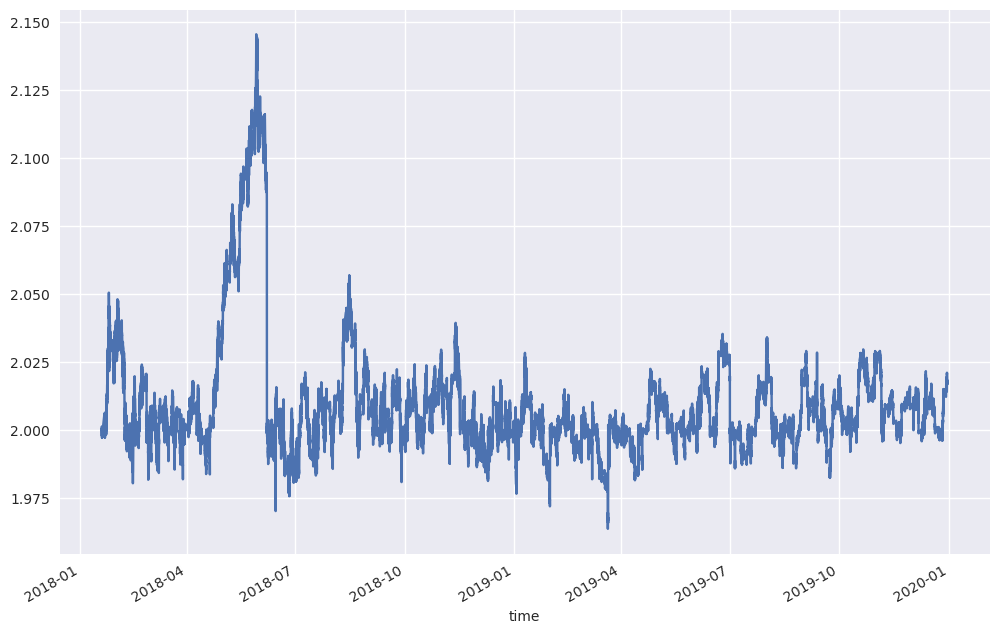

In [47]:
data.eff_lev.plot(figsize = (12, 8))
plt.show()

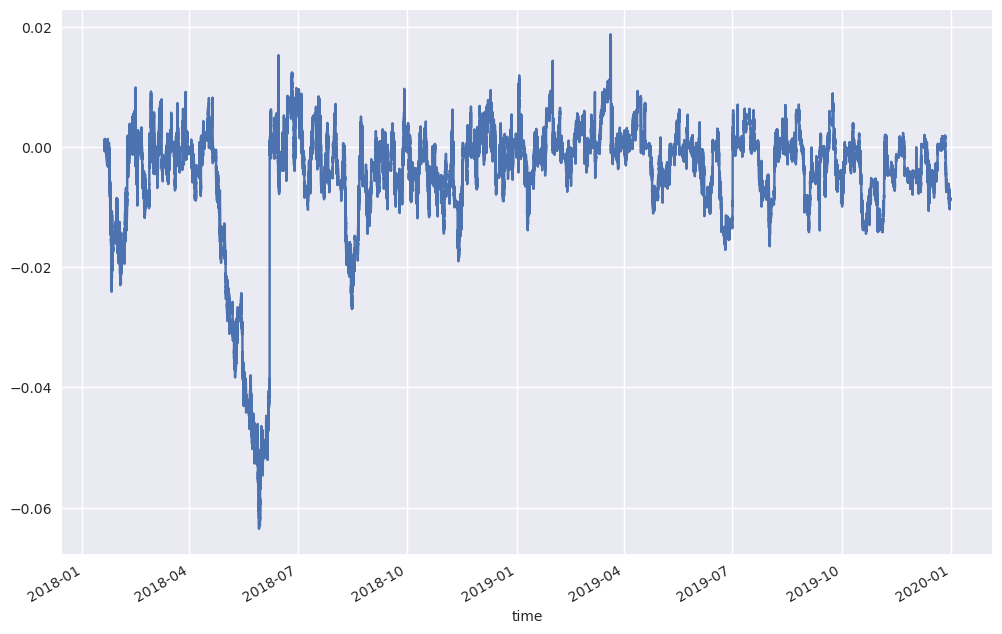

In [48]:
tester.add_sessions(True)

In [49]:
data

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev
time,,,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN,NaN,2.000000
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049,-0.000049,2.000098
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033,0.000016,2.000065
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131,-0.000098,2.000262
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180,-0.000049,2.000360
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772


In [50]:
levered_returns = data.eff_lev.shift() * data.simple_ret 
levered_returns

time
2018-01-19 16:53:00         NaN
2018-01-19 16:54:00   -0.000098
2018-01-19 16:55:00    0.000033
2018-01-19 16:56:00   -0.000196
2018-01-19 16:57:00   -0.000098
                         ...   
2019-12-30 23:56:00    0.000000
2019-12-30 23:57:00    0.000000
2019-12-30 23:58:00    0.000000
2019-12-30 23:59:00    0.000090
2019-12-31 00:00:00   -0.000054
Length: 717739, dtype: float64

In [51]:
levered_returns = pd.Series(np.where(levered_returns < -1, -1, levered_returns))
levered_returns

0              NaN
1        -0.000098
2         0.000033
3        -0.000196
4        -0.000098
            ...   
717734    0.000000
717735    0.000000
717736    0.000000
717737    0.000090
717738   -0.000054
Length: 717739, dtype: float64

In [52]:
levered_returns.add(1).cumprod()

0              NaN
1         0.999902
2         0.999935
3         0.999738
4         0.999640
            ...   
717734    1.984177
717735    1.984177
717736    1.984177
717737    1.984355
717738    1.984248
Length: 717739, dtype: float64

## The updated Conbacktester Class (Leverage)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [54]:
# Version 6.0 (Leverage)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    add_leverage:
        adds leverage to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
            
    def plot_results(self, leverage = False): # adj!!!
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage: # NEW!!!
            title = "{} | Window = {} | Frequency = {} | TC = {} | Leverage = {}".format(self.symbol, self.window, self.freq, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | Window = {} | Frequency = {} | TC = {}".format(self.symbol, self.window, self.freq, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True):
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
        
    def add_leverage(self, leverage, sl = -0.5, report = True): # NEW!!!
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        sl: float (negative), default -50% (regulatory)
            maximum margin loss level in % (e.g. -0.2 for -20%).
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        
        self.leverage = leverage
        sl_thresh = sl / leverage
        self.add_stop_loss(sl_thresh, report = False)
        
        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()
        
        self.results = data
            
        if report:
            self.print_performance(leverage = True)
    ############################## Performance ######################################
    
    def print_performance(self, leverage = False): # adj!!!
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        
        if leverage:
            to_analyze = np.log(data.strategy_levered.add(1))
        else: 
            to_analyze = data.strategy
        
        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)
        sortino =           round(self.calculate_sortino(to_analyze), 6)
        max_drawdown =      round(self.calculate_max_drawdown(to_analyze), 6)
        calmar =            round(self.calculate_calmar(to_analyze), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(to_analyze), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(to_analyze), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [55]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [56]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [57]:
tester.test_strategy(201, 101)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126


In [58]:
tester.add_leverage(leverage = 2, sl = -0.5, report = True)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.984248
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       1.068696


CAGR:                        0.422638
Annualized Mean:             0.353284
Annualized Std:              0.136298
Sharpe Ratio:                2.591995
Sortino Ratio:               3.698538
Maximum Drawdown:            0.129489
Calmar Ratio:                3.263898
Max Drawdown Duration:       84 Days
Kelly Criterion:             19.516839


In [59]:
tester.results

,price,returns,position,strategy,trades,creturns,cstrategy,session,session_compound,simple_ret,eff_lev,strategy_levered,cstrategy_levered
time,,,,,,,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN,0.0,NaN,NaN,2.000000,NaN,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951,0.0,-0.000049,-0.000049,2.000098,-0.000098,0.999902
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967,0.0,-0.000033,0.000016,2.000065,0.000033,0.999935
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869,0.0,-0.000131,-0.000098,2.000262,-0.000196,0.999738
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820,0.0,-0.000180,-0.000049,2.000360,-0.000098,0.999640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772,0.000000,1.984177
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772,0.000000,1.984177
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200,252.0,-0.008731,0.000000,2.017772,0.000000,1.984177


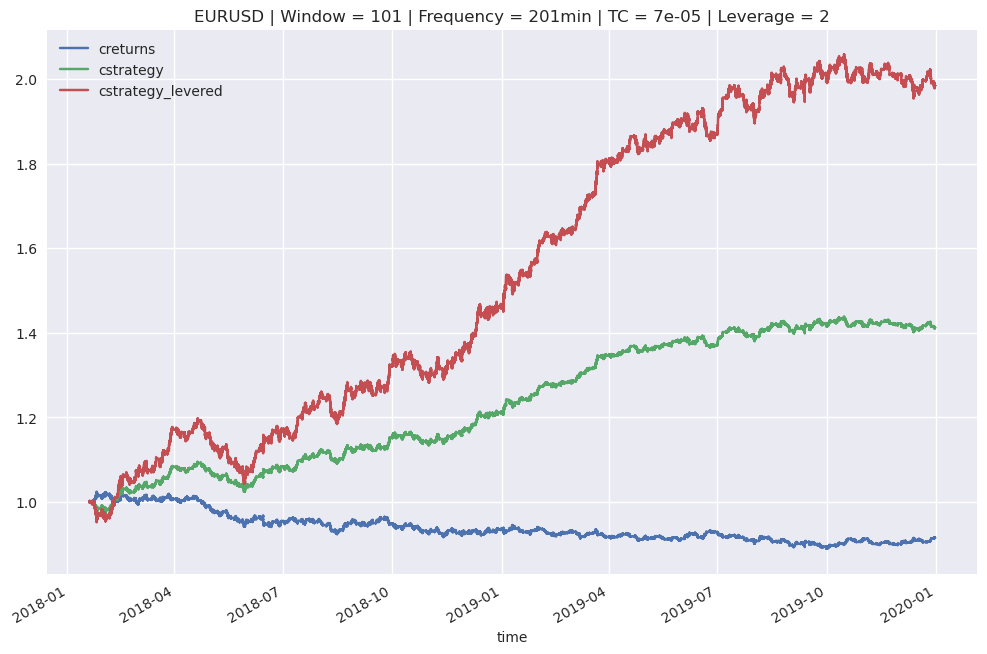

In [60]:
tester.plot_results(leverage = True)

## Revised: The optimal degree of leverage

In [61]:
tester.test_strategy(201, 101)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126


In [62]:
leverage = np.arange(1, 50, 1)
leverage

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

__No constant leverage, No Stop Loss (@ -100%)__

In [63]:
multiple = []
for lever in leverage:
    tester.add_leverage(leverage = lever, sl = -1, report = False)
    multiple.append(tester.results.cstrategy_levered[-1])
results = pd.DataFrame(data = {"Leverage": leverage, "Multiple_100":multiple})   

In [64]:
results.set_index("Leverage", inplace = True)

In [65]:
results

,Multiple_100
Leverage,
1,1.412225
2,1.984248
3,2.773535
4,3.856251
5,5.332482
6,7.332509
7,10.024137
8,13.620951
9,18.391102


In [66]:
results.min()

Multiple_100    0.0
dtype: float64

In [67]:
results.max()

Multiple_100    94.978599
dtype: float64

In [68]:
results.idxmax()

Multiple_100    15
dtype: int64

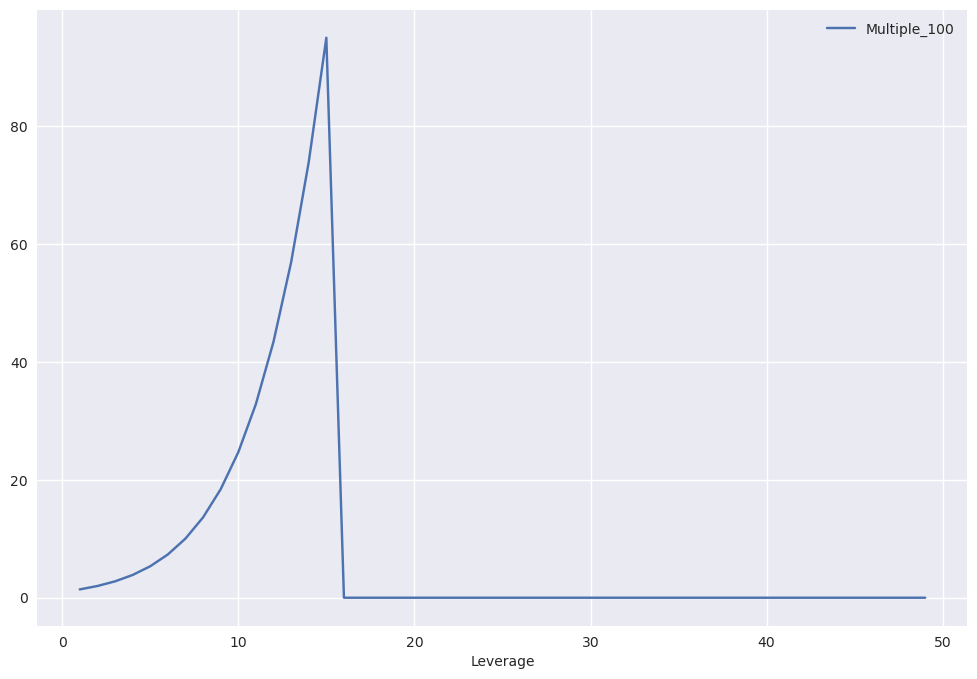

In [69]:
results.plot(figsize = (12, 8));
plt.show()

In [70]:
sls = [-0.5, -0.4, -0.25]
label = ["Multiple_50", "Multiple_40", "Multiple_25"]

__No constant leverage, Stop Loss @ [-50%, -40%, -25%]__

In [71]:
for i in range(len(sls)):
    tester.test_strategy(201, 101)
    multiple = []
    for lever in leverage:
        tester.add_leverage(leverage = lever, sl = sls[i], report = False)
        multiple.append(tester.results.cstrategy_levered[-1])
    results[label[i]] = multiple 

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
-----------------------

In [72]:
results

,Multiple_100,Multiple_50,Multiple_40,Multiple_25
Leverage,,,,
1,1.412225,1.412225,1.412225,1.412225
2,1.984248,1.984248,1.984248,1.984248
3,2.773535,2.773535,2.773535,2.773535
4,3.856251,3.856251,3.856251,3.408214
5,5.332482,5.332482,5.332482,4.949027
6,7.332509,7.332509,7.332509,7.146652
7,10.024137,10.024137,8.192352,10.272638
8,13.620951,9.752092,11.793068,14.741145
9,18.391102,14.014819,16.875530,21.096523


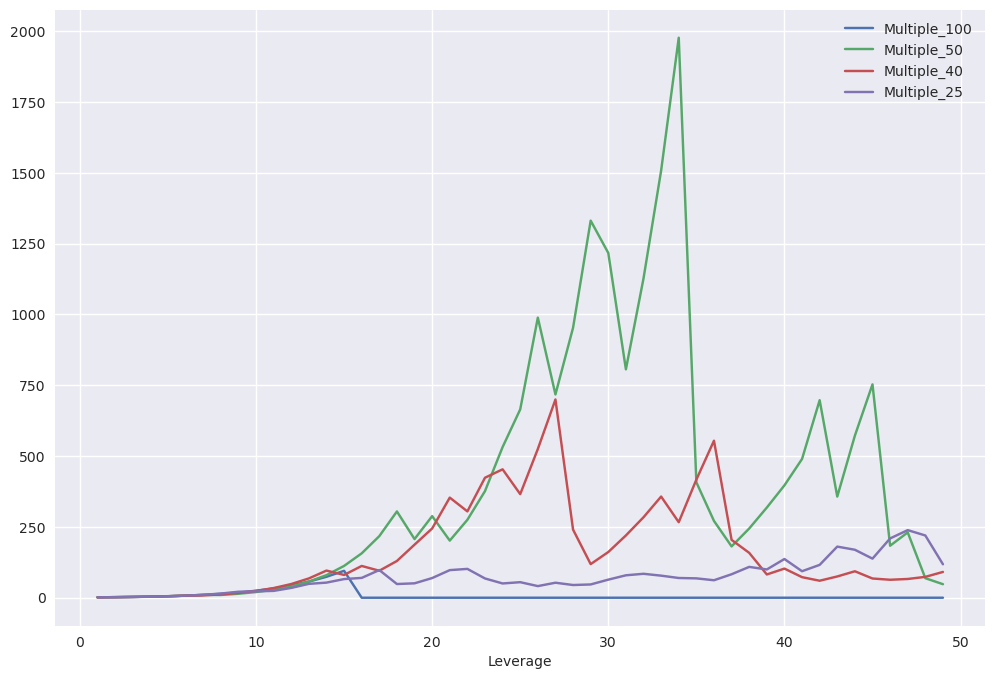

In [73]:
results.plot(figsize = (12, 8));
plt.show()

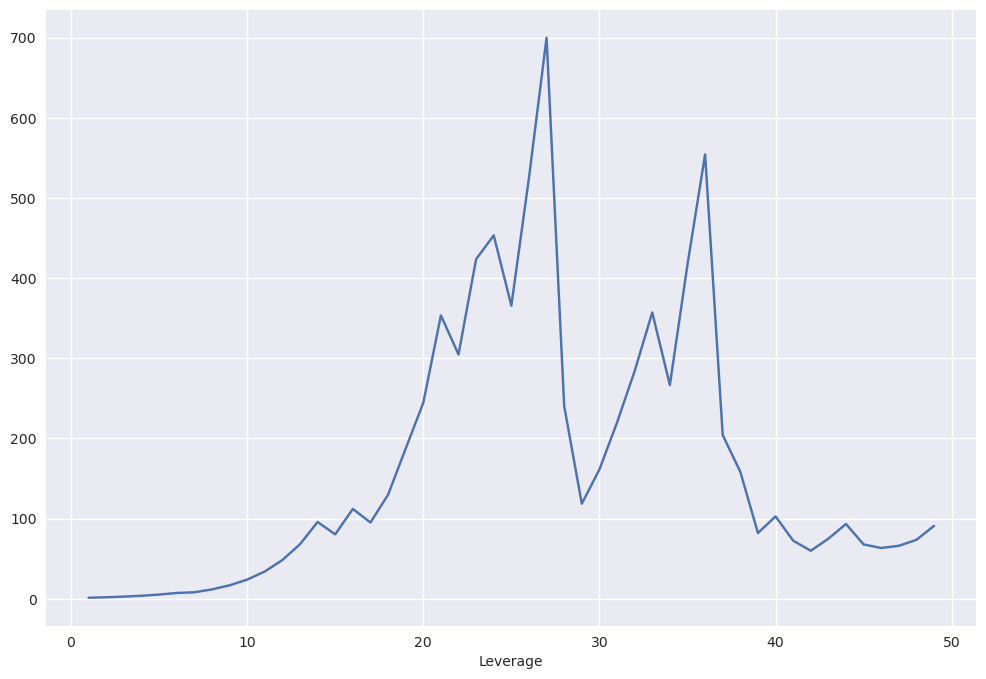

In [74]:
results.Multiple_40.plot(figsize = (12, 8))
plt.show()